# Chapter 6: Frequency Domain Filtering

In [7]:
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
import numpy.fft as nfp
from scipy import ndimage, misc, signal
from skimage import data, color, restoration, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
import numpy as np
import numpy.fft
import timeit
import warnings
warnings.filterwarnings('ignore')

## Filtering in the frequency domain (HPF, LPF, BPF, and notch filters)

### High-Pass Filter (HPF)

In [ ]:
im = np.array(Image.open('images/rhino.jpg').convert('L'))
plt.figure(figsize=(10,10)), plt.imshow(im, cmap=plt.cm.gray), plt.axis('off')
plt.show()

In [ ]:
freq = fp.fft2(im)
(h, w) = freq.shape
half_w, half_h = int(w/2), int(h/2)
freq1 = np.copy(freq)
freq2 = fp.fftshift(freq1)
plt.figure(figsize=(10,10)), plot_spectrum(freq2, 'log')
plt.show()

In [ ]:
# apply HPF
freq2[half_h-10:half_h+11,half_w-10:half_w+11] = 0 # select all but the first 20x20 (low) frequencies
plt.figure(figsize=(10,10))
plot_spectrum(freq2, 'log')
plt.show()

In [ ]:
im1 = np.clip(fp.ifft2(fp.ifftshift(freq2)).real,0,255) # clip pixel values after IFFT
print(psnr(im, im1))
# 6.867478436727171
plt.imshow(im1, cmap='gray'), plt.axis('off')
plt.show()

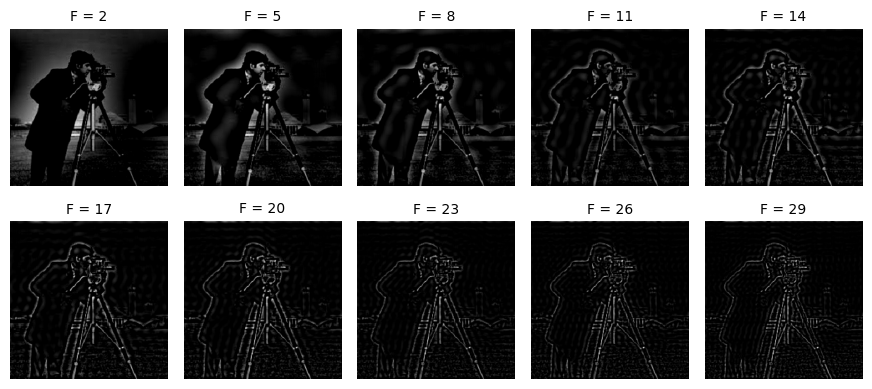

In [161]:
im = np.array(Image.open('images/cameraman.jpg').convert('L'))
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
snrs_hp = []
lbs = list(range(1,30,3))
plt.figure(figsize=(11,5))
for l in lbs:
    freq1 = np.copy(freq)
    freq2 = fp.fftshift(freq1)
    freq2[half_w-l:half_w+l+1,half_h-l:half_h+l+1] = 0 # select all but the first lxl (low) frequencies
    im1 = np.clip(fp.ifft2(fp.ifftshift(freq2)).real,0,255) # clip pixel values after IFFT
    snrs_hp.append(psnr(im, im1))
    plt.subplot(2,5,l//3+1), plt.imshow(im1, cmap='gray'), plt.axis('off')
    plt.title('F = ' + str(l+1), size=10)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

### How SNR changes with frequency cut-off

The following code block shows how to plot the change in the *peak signal to noise ratio* (**PSNR**)
with the cutoff frequency ($F$) for the HPF. The next figure shows how the PSNR of the output image decreases with the
increase in the cutoff frequency of the HPF.

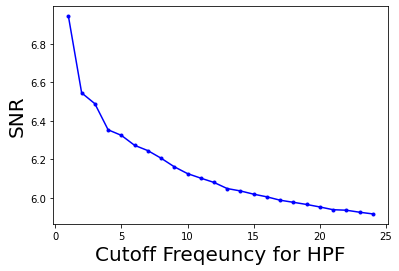

In [48]:
plt.plot(lbs, snrs_hp, 'b.-')
plt.xlabel('Cutoff Freqeuncy for HPF', size=20)
plt.ylabel('SNR', size=20)
plt.show()

### Ideal, Butterworth, Gaussian HPFs

In [108]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_spectrum_3d(F, ax, cmap='jet', title=''):
 h, w = F.shape[0], F.shape[1]
 X, Y = range(-int(np.floor(w/2)),int(np.ceil(w/2))), range(-int(np.floor(h/2)),int(np.ceil(h/2)))
 Y, X = np.meshgrid(X, Y)
 surf = ax.plot_surface(X, Y, F, cmap=cmap, linewidth=0, antialiased=False, rstride=5,	cstride=5,	alpha=0.8)
 ax.set_xlim(-h//2, h//2)
 ax.set_ylim(-w//2, w//2)
 #ax.xaxis.set_major_locator(LinearLocator(0.1))
 #ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
 #ax.view_init(elev=10.) #,	azim=5)
 ax.set_title(title,	size=15)

def plot_all(f, g, F, H, title):
    #plt.figure(figsize=(5,3)) 
    plt.figure(figsize=(10,7))
    plt.gray()
    plt.subplot(121), plt.imshow(f), plt.axis('off')
    plt.subplot(122), plt.imshow(g), plt.axis('off')
    plt.suptitle(title, size=15)
    plt.tight_layout()
    plt.show()
    
    fig, axes =	plt.subplots(subplot_kw={"projection": "3d"}, nrows=1, ncols=3, figsize=(11,5))
    axes = axes.ravel()
    plot_spectrum_3d(20*np.log10(0.01 + np.abs(F)), axes[0], title='log F(u,v)')
    plot_spectrum_3d(np.abs(H), axes[1], title='H(u,v)')
    plot_spectrum_3d(20*np.log10(0.01 + np.abs(G)), axes[2], title='log G(u,v)')
    plt.tight_layout()
    plt.show()

In [109]:
def dist(u, v):
    return np.sqrt(u**2 + v**2)

def get_grid(w, h):
    return np.meshgrid(range(-int(np.floor(w/2)),int(np.ceil(w/2))), range(-int(np.floor(h/2)),int(np.ceil(h/2)))) #, sparse=True)

def ideal(sz, D0):
    h, w = sz
    u, v = get_grid(w, h)
    return dist(u,v) > D0
    
def gaussian(sz, D0):
    h, w = sz
    u, v = get_grid(w, h)
    return 1-np.exp(-dist(u,v)**2/(2*D0**2)) 

def butterworth(sz, D0, n=2):
    h, w = sz
    u, v = get_grid(w, h)
    return 1 / (1 + (D0 / (0.001+dist(u,v)))**(2*n))

def laplacian(sz):
    h, w = sz
    u, v = get_grid(w, h)
    return 1-(dist(u,v))**2 

def apply_filter(f, func, arg_dict):
    F = fp.fftshift(fp.fft2(f))
    H = func(**arg_dict) 
    G	=	H * F
    g	=	np.abs(fp.ifft2(G))
    g = g / g.max()
    return F, H, G, g

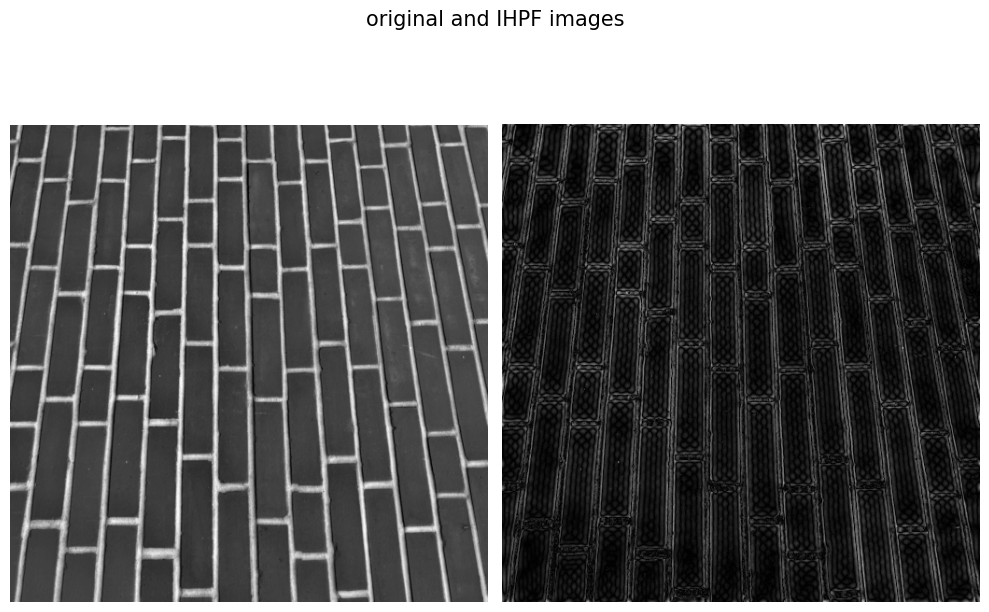

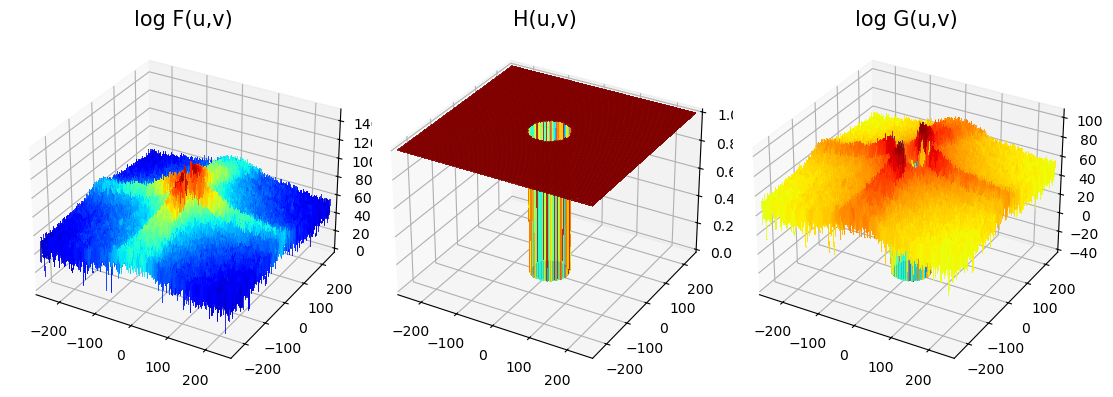

In [110]:
from skimage import data, filters
from skimage.util import random_noise

#dir(data)
f = data.brick()

F, H, G, g = apply_filter(f, ideal, {'sz':f.shape, 'D0':50})
plot_all(f, g, F, H, 'original and IHPF images')

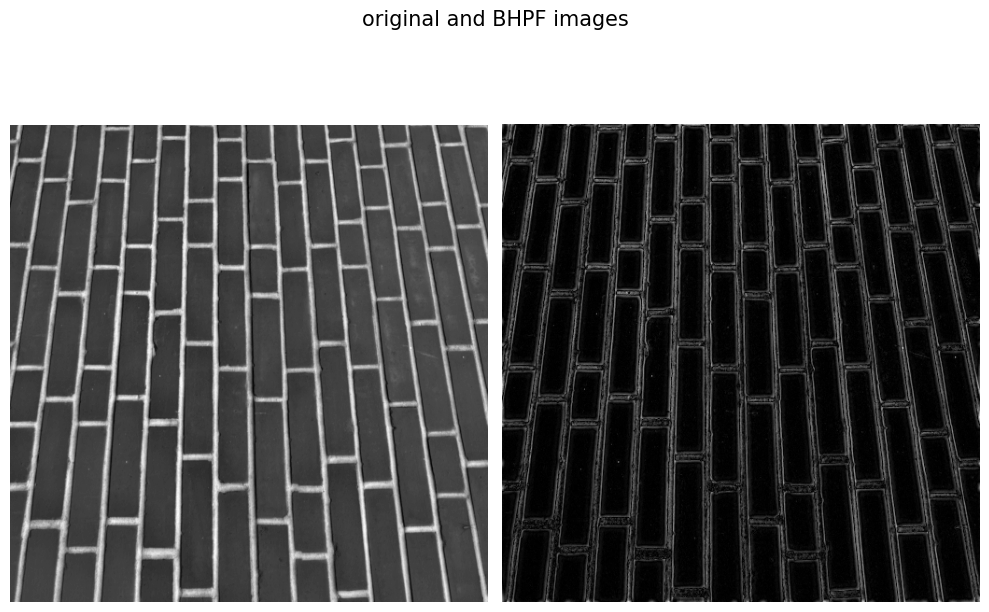

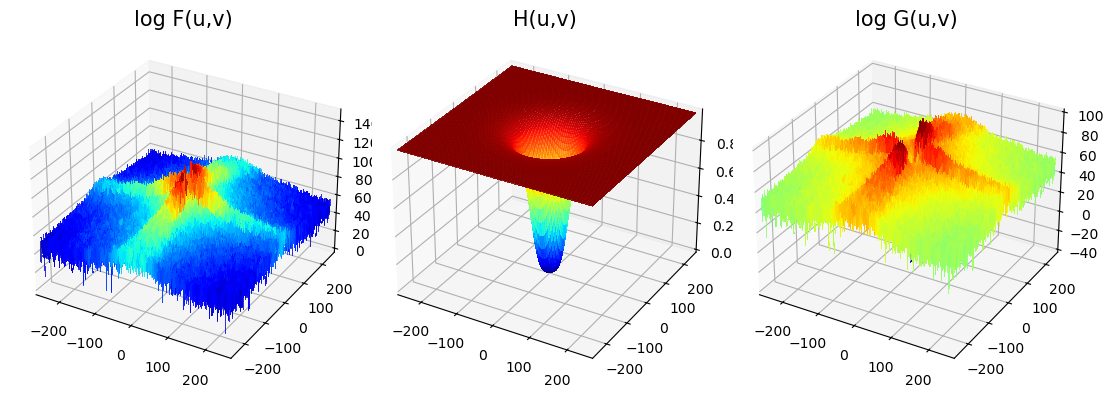

In [111]:
F, H, G, g = apply_filter(f, butterworth, {'sz':f.shape, 'D0':50, 'n':2})
plot_all(f, g, F, H, 'original and BHPF images')

In [ ]:
F, H, G, g = apply_filter(f, gaussian, {'sz':f.shape, 'D0':50})
plot_all(f, g, F, H, 'original and GHPF images')

## Low-pass filter (LPF)

### LPF with `fourier_gaussian`

In [ ]:
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(20,10))
plt.gray() # show the result in grayscale
im = np.mean(imread('images/lena.jpg'), axis=2)
freq = nfp.fft2(im)
freq_gaussian = ndimage.fourier_gaussian(freq, sigma=4)
im1 = nfp.ifft2(freq_gaussian)
axes1.imshow(im), axes1.axis('off'), axes2.imshow(im1.real) # the imaginary part is an artifact
axes2.axis('off')
plt.show()

The following figure shows the output of the next code block and displays the frequency spectrum of the image after the Gaussian kernel is applied:

In [ ]:
plt.figure(figsize=(10,10))
plot_spectrum(nfp.fftshift(freq_gaussian), 'log')
plt.show()

### LPF with `scipy.fftpack`

In [ ]:
im = np.array(Image.open('images/rhino.jpg').convert('L'))
# low pass filter
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
freq1 = np.copy(freq)
freq2 = fp.fftshift(freq1)
freq2_low = np.copy(freq2)
freq2_low[half_w-10:half_w+11,half_h-10:half_h+11] = 0 # block the lowfrequencies
freq2 -= freq2_low # select only the first 20x20 (low) frequencies, block the high frequencies
im1 = fp.ifft2(fp.ifftshift(freq2)).real
print(psnr(im, im1))
# 2.389151856495427
plt.imshow(im1, cmap='gray'), plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow( (20*np.log10( 0.1 + freq2)).astype(int))
plt.show()

The following code block shows the application of LPF on the cameraman grayscale image, with different frequency cutoff values, $F$. The next figure shows how LPF detects more and more details in the image as the cutoff frequency, $F$, increases:

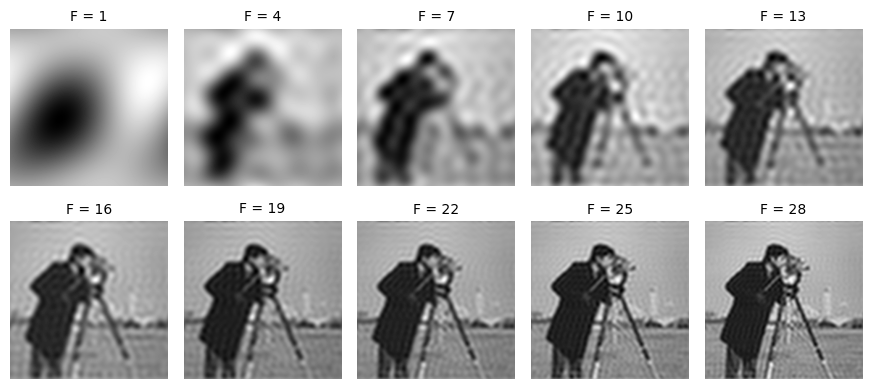

In [148]:
im = np.array(Image.open('images/cameraman.jpg').convert('L'))
freq = fp.fft2(im)
(w, h) = freq.shape
half_w, half_h = int(w/2), int(h/2)
snrs_lp = []
ubs = list(range(1,30,3))
plt.figure(figsize=(11,5))
for u in ubs:
    freq1 = np.copy(freq)
    freq2 = fp.fftshift(freq1)
    freq2_low = np.copy(freq2)
    freq2_low[half_w-u:half_w+u+1,half_h-u:half_h+u+1] = 0
    freq2 -= freq2_low # select only the first 20x20 (low) frequencies
    im1 = fp.ifft2(fp.ifftshift(freq2)).real
    snrs_lp.append(psnr(im, im1))
    plt.subplot(2,5,u//3+1), plt.imshow(im1, cmap='gray'), plt.axis('off')
    plt.title('F = ' + str(u), size=10)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

### How SNR changes with frequency cutoff

The following code snippet shows how to plot the change in *peak signal to noise ratio* (**PSNR**) with cutoff frequency ($F$) for LPF. The following screenshot shows how SNR of the output image increases with the increase
in the cut-off frequency of LPF (indicating better reconstruction).

In [ ]:
plt.plot(ubs, snrs_lp, 'b.-')
plt.xlabel('Cutoff Freqeuncy for LPF', size=20)
plt.ylabel('PSNR', size=20)
plt.show()

### Ideal, Butterworth, Gaussian LPFs

In [112]:
def ideal(sz, D0):
    h, w = sz
    u, v = get_grid(w, h)
    return dist(u,v) < D0
    
def gaussian(sz, D0):
    h, w = sz
    u, v = get_grid(w, h)
    return np.exp(-dist(u,v)**2/(2*D0**2)) 

def butterworth(sz, D0, n=2):
    h, w = sz
    u, v = get_grid(w, h)
    return 1 / (1 + (dist(u,v)/D0)**(2*n))

def laplacian(sz):
    h, w = sz
    u, v = get_grid(w, h)
    return -(dist(u,v))**2 

In [ ]:
from skimage import data, filters
from skimage.util import random_noise

#dir(data)
f = data.camera()
f = random_noise(f, var=0.1)

F, H, G, g = apply_filter(f, ideal, {'sz':f.shape, 'D0':20})
plot_all(f, g, F, H, 'original and ILF images')

In [ ]:
F, H, G, g = apply_filter(f, butterworth, {'sz':f.shape, 'D0':20, 'n':2})
plot_all(f, g, F, H, 'original and BLPF images')

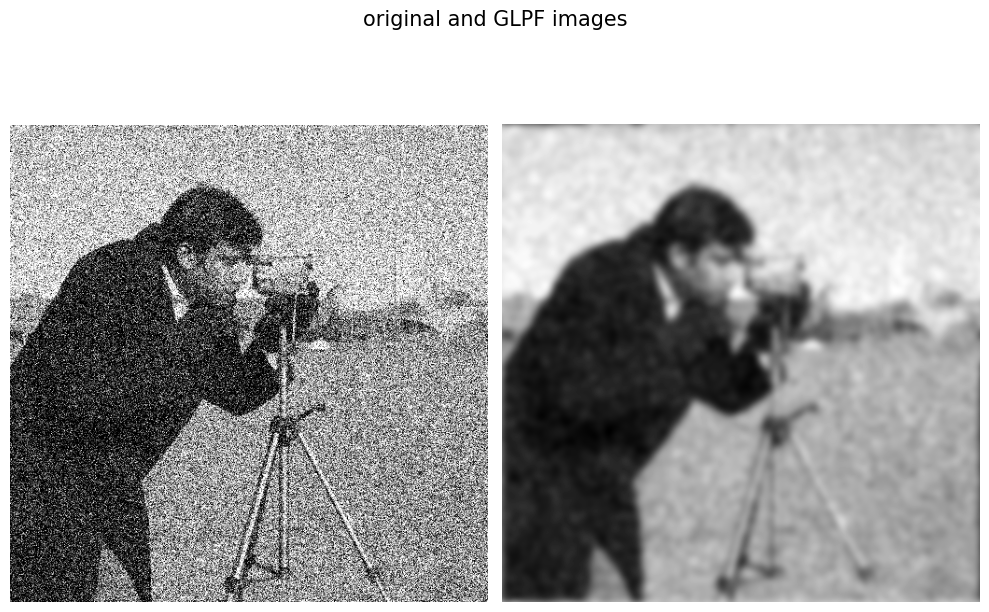

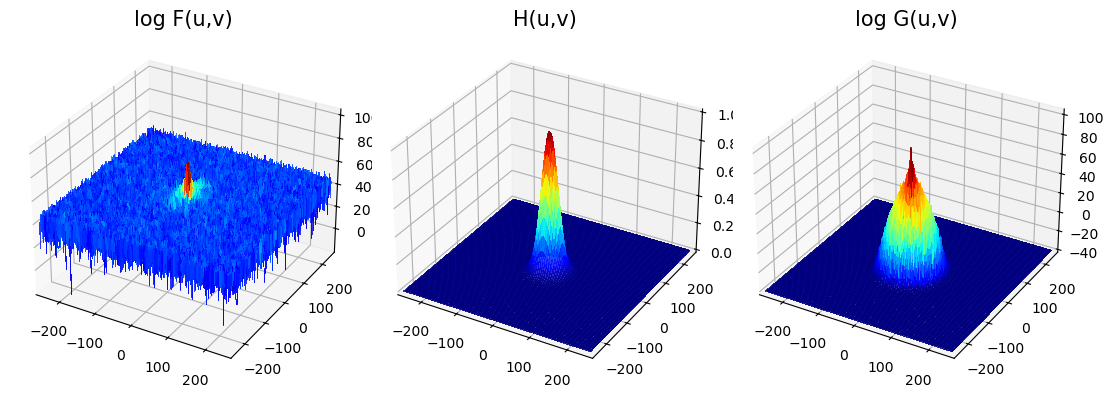

In [115]:
F, H, G, g = apply_filter(f, gaussian, {'sz':f.shape, 'D0':20})
plot_all(f, g, F, H, 'original and GLPF images')

### with skimage.filters

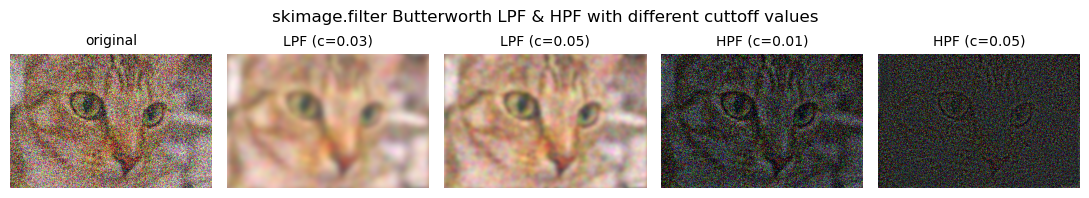

In [245]:
#dir(data)
im = data.chelsea()
im = random_noise(im, var=0.2)
im = im / im.max()
images, titles = [im], ['original']
for c in [0.03, 0.05]:
    im_lpf = filters.butterworth(
                    im,
                    cutoff_frequency_ratio=c,
                    order=2,
                    high_pass=False,
                    squared_butterworth=True,
                    npad=0,
                    channel_axis=-1
                )
    im_lpf = np.clip(im_lpf / im_lpf.max(), 0, 1)
    images.append(im_lpf)
    titles.append(f'LPF (c={c})')
for c in [0.01, 0.05]:
    im_hpf = filters.butterworth(
                im,
                cutoff_frequency_ratio=c,
                order=2,
                high_pass=True,
                squared_butterworth=True,
                npad=0,
                channel_axis=-1
            )
    im_hpf = np.clip(im_hpf / im_hpf.max(), 0, 1)
    images.append(im_hpf)
    titles.append(f'HPF (c={c})')
plt.figure(figsize=(11,2))
plt.gray()
for i, (im, title) in enumerate(zip(images, titles)):
    plt.subplot(1,5,i+1), plt.imshow(im), plt.title(title, size=10), plt.axis('off')
plt.suptitle('skimage.filter Butterworth LPF & HPF with different cuttoff values', size=12)
plt.tight_layout()
plt.show()

### Homomorphic Filter

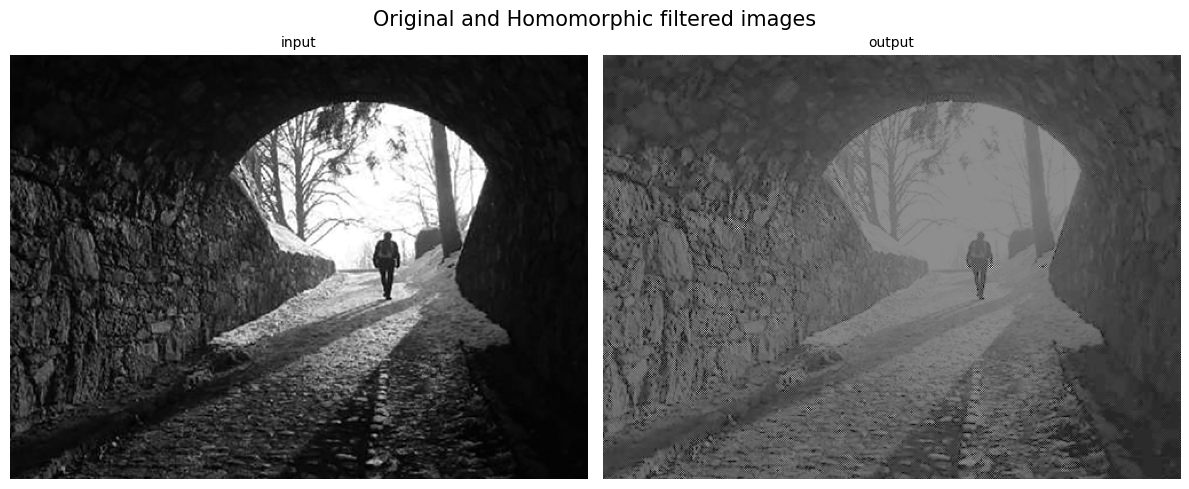

In [252]:
def homomorphic_filter(f, D0, γ_l, γ_h, c):
    h, w = f.shape
    u, v = get_grid(w, h)
    D = dist(u, v)
    # n =2; H = 1 / (1 + (D0/D)**(2*n)) # butterworth high-pass
    H = 1 - np.exp(-c*D**2/(D0**2)) # gaussian high-pass
    H = ((γ_h - γ_l)*H) + γ_l
    H = 1 - H
    F = np.fft.fft2(np.log2(1+f))
    G = H * F  # by convolution theorem
    g = np.exp(np.abs(np.fft.ifft2(G)))
    return g

import numpy as np
from skimage.io import imread
np.seterr(divide='ignore')

im = imread('images/tunnel.png', as_gray=True)
im_scaled = (255*im/im.max()).astype(np.float32) # have pixel values scaled in between [0-255]
im_out = homomorphic_filter(im_scaled, D0 = 20, γ_l = .0999, γ_h = 1.01, c = 0.5)

plt.figure(figsize=(12,5))
plt.subplot(121), plt.imshow(im), plt.axis('off'), plt.title('input', size=10)
plt.subplot(122), plt.imshow(im_out_freq), plt.axis('off'), plt.title('output', size=10)
plt.suptitle('Original and Homomorphic filtered images', size=15)
plt.tight_layout()
plt.show()

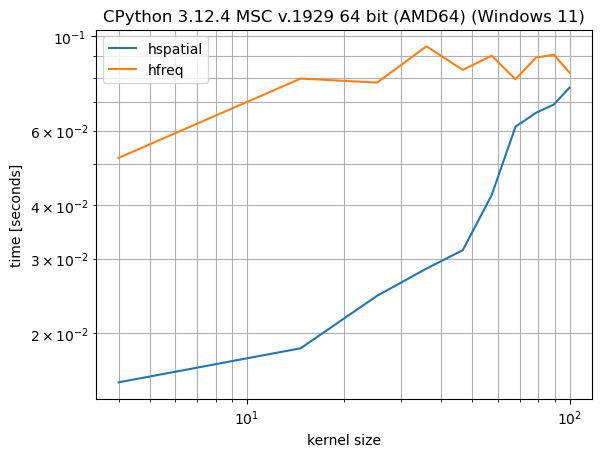

In [264]:
def hspatial(s): # spatial
    f = im 
    return homomorphic_filter_spatial(f, g_l, g_h, s)

def hfreq(s): # frequency
    f = im_scaled 
    return homomorphic_filter_freq(f, D0, γ_l, γ_h, c)

from simple_benchmark import benchmark
from datetime import timedelta

np.seterr(divide='ignore')
np.random.seed(1)

im = imread('images/tunnel.png', as_gray=True)
im_scaled = (255*im/im.max()).astype(np.float32) # have pixel values scaled in between [0-255]
D0, γ_l, γ_h, c = 20, .0999, 1.01, 0.25
g_l, g_h = 0.59, 0.41

b = benchmark(
    [hspatial, hfreq],
    {4*s: s for s in np.linspace(1, 25, 10)}, # kernel size = 4*s, implemented using scipy.ndimage.gaussian
    #time_per_benchmark=timedelta(milliseconds=10000),
    #maximum_time=timedelta(milliseconds=10000)
)

b.plot()
plt.xlabel('kernel size', size=10);
plt.show()

### Laplacian in Frquecncy Domain

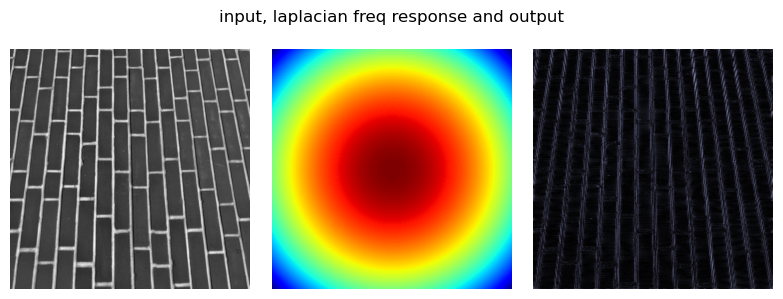

In [47]:
import cv2
import numpy as np
from skimage import data

f = data.brick()
f = f / f.max()
h, w = f.shape
F = np.fft.fftshift(cv2.dft(f))
u, v = np.meshgrid(range(-w//2,w//2), range(-h//2,h//2))
H = (lambda u, v: -(dist(u,v))**2)(u, v)
G = F*H
g = np.abs(cv2.idft(G))
g = g / g.max()
plt.figure(figsize=(8,3))
plt.subplot(131), plt.imshow(f, cmap='gray'), plt.axis('off')
plt.subplot(132), plt.imshow(H, cmap='jet'), plt.axis('off')
plt.subplot(133), plt.imshow(g, cmap='bone'), plt.axis('off')
plt.suptitle('input, laplacian freq response and output')
plt.tight_layout()

## Band-pass filter (BPF) with DoG

The Difference of Gaussian (**DoG**) kernel can be used as a BPF to allow the frequencies in
a certain band and discard all other frequencies. The following code block shows how the
DoG kernel can be used with fftconvolve() to implement a BPF. The next figure shows the output of the preceding code block, the output image obtained with the BPF:

In [ ]:
im = img_as_float(plt.imread('images/tigers.jpeg'))
plt.figure(), plt.imshow(im), plt.axis('off'), plt.show()
x = np.linspace(-10, 10, 15)
kernel_1d = np.exp(-0.005*x**2)
kernel_1d /= np.trapz(kernel_1d) # normalize the sum to 1
gauss_kernel1 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]
kernel_1d = np.exp(-5*x**2)
kernel_1d /= np.trapz(kernel_1d) # normalize the sum to 1
gauss_kernel2 = kernel_1d[:, np.newaxis] * kernel_1d[np.newaxis, :]
DoGKernel = gauss_kernel1[:, :, np.newaxis] - gauss_kernel2[:, :, np.newaxis]
im = signal.fftconvolve(im, DoGKernel, mode='same')
plt.figure(), plt.imshow(np.clip(im, 0, 1)), print(np.max(im)),
plt.show()

### Ideal, Butterworth, Gaussian BPFs

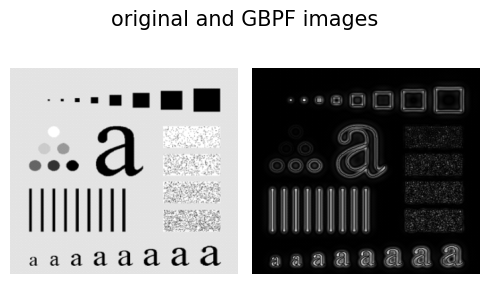

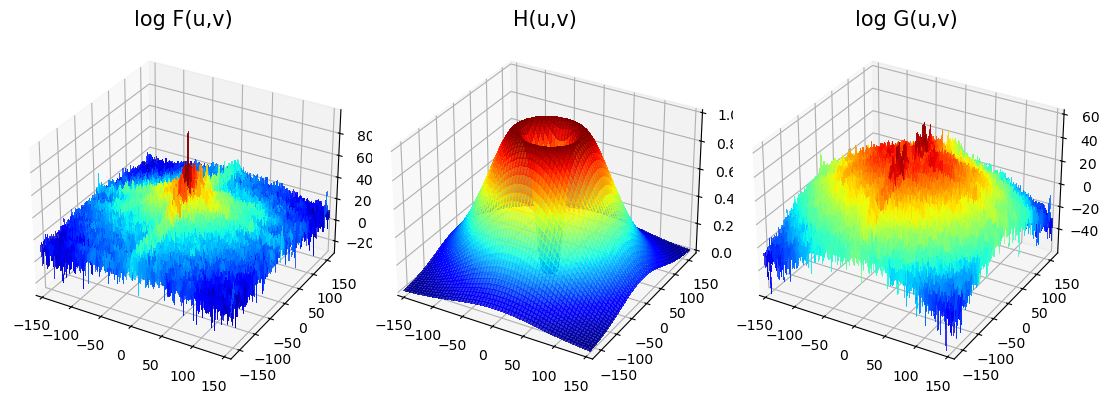

In [230]:
from skimage.io import imread

def ideal(sz, D0, W):
    h, w = sz
    u, v = get_grid(w, h)
    D = dist(u,v)
    return (D >= D0 - W/2) & (D < D0 + W/2)
    
def gaussian(sz, D0, W):
    h, w = sz
    u, v = get_grid(w, h)
    D = dist(u,v)
    return np.exp(-(D**2-D0**2)**2/(D*W)**2) 
    
f = imread('images/aaa.png', as_gray=True) #data.brick()
f = f / f.max()
F, H, G, g = apply_filter(f, gaussian, {'sz':f.shape, 'D0':50, 'W':100})
plot_all(f, g, F, H, 'original and GBPF images')

## Band-stop (notch) filter

This filter blocks/rejects a few chosen frequencies from the frequency domain
representation of the image (obtained with DFT), and hence the name. It is useful for
removing periodic noise from images, as discussed in the next section.

### Using a notch filter to remove periodic noise from images

In this example, we will first add some periodic (sinusoidal) noise to the parrot image to
create a noisy parrot image (this can happen because of interference with some electrical
signal) and then observe the effect of the noise in the frequency domain of the image using
the following code snippet. The following screenshot shows the output of the preceding code block. As can be seen, the
periodic noise there on the horizontal line became more prominent in the frequency
spectrum around $u = 175$:

(340, 453)


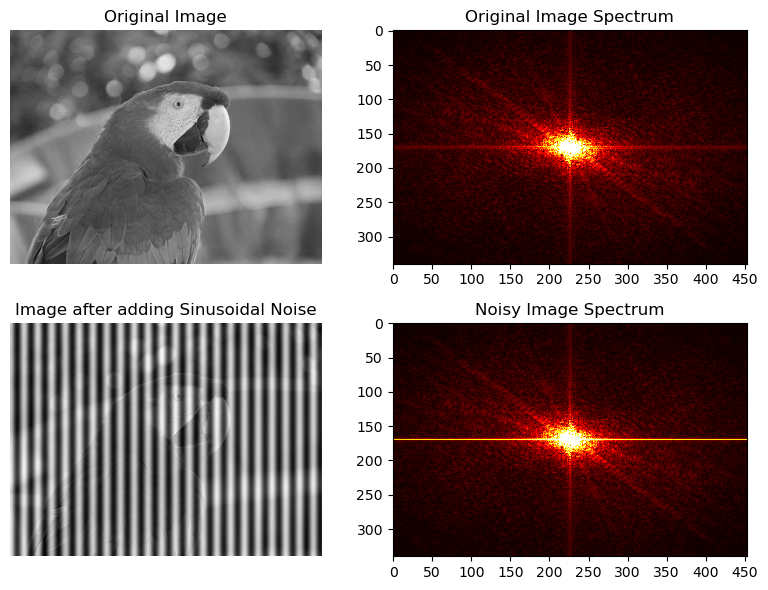

In [164]:
def plot_spectrum(F, method=None, cmap='coolwarm'):
    F_disp = (20*np.log10(0.01 + np.abs(F))).astype(int) if method == 'log' else np.minimum(np.abs(F).astype(int)+100, 255) 
    plt.imshow(F_disp, cmap=cmap, aspect='auto')

plt.figure(figsize=(8,6))
im =  np.mean(imread("images/parrot.jpg"), axis=2) 
im = im / im.max()
print(im.shape)
plt.subplot(2,2,1), plt.imshow(im, cmap='gray'), plt.axis('off')
plt.title('Original Image')
F1 = fp.fft2((im).astype(float))
F2 = fp.fftshift( F1 )
plt.subplot(2,2,2), plot_spectrum(F2, cmap=plt.cm.hot)
plt.xticks(np.arange(0, im.shape[1], 50))
plt.yticks(np.arange(0, im.shape[0], 50))
plt.title('Original Image Spectrum')
# add periodic noise to the image
for n in range(im.shape[1]):
    im[:, n] += np.cos(0.1*np.pi*n)
plt.subplot(2,2,3), plt.imshow(im, cmap='gray'), plt.axis('off')
plt.title('Image after adding Sinusoidal Noise')
F1 = fp.fft2((im).astype(float)) # noisy spectrum
F2 = fp.fftshift( F1 )
plt.subplot(2,2,4), plot_spectrum(F2, cmap=plt.cm.hot)
plt.xticks(np.arange(0, im.shape[1], 50))
plt.yticks(np.arange(0, im.shape[0], 50))
plt.title('Noisy Image Spectrum')
plt.tight_layout()
plt.show()

Now let's design a band-stop/band-reject (notch) filter to eliminate the frequencies that are responsible for noise by setting the corresponding frequency components to zero in the next code snippet. The following screenshot shows the output of the preceding code block, the restored image by applying the notch filter. As can be seen, the original image looks sharper than the restored one, since some true frequencies from the original image are also rejected by the
band-reject filter along with the noise.

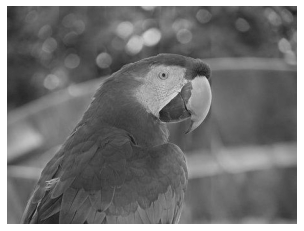

In [84]:
F2[170:176,:220] = F2[170:176,230:] = 0 # eliminate the frequencies most likely responsible for noise (keep some low frequency components)
im1 = fp.ifft2(fp.ifftshift( F2 )).real
plt.axis('off'), plt.imshow(im1, cmap='gray')
plt.show()

### The Gaussian Bandstop Filter

$$H_{LP}(u,v)=e^{-D^2(u,v)/2D_L^2}$$
$$H_{HP}(u,v)=1-e^{-D^2(u,v)/2D_H^2}$$
$$H_{BR}=H_{LP}*H_{HP}$$

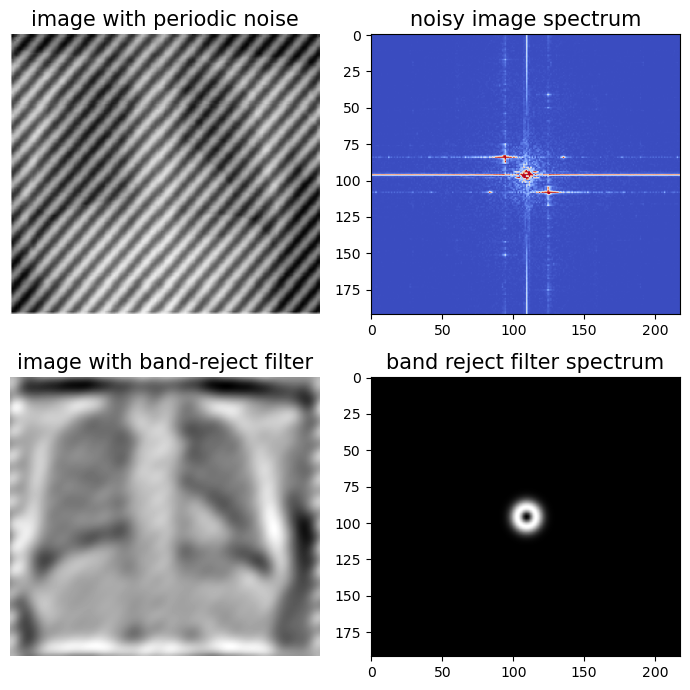

In [162]:
def plot_spectrum(F, ax, method=None, cmap='coolwarm'):
    F_disp = (20*np.log10(0.01 + np.abs(F))).astype(int) if method == 'log' else np.minimum(np.abs(F).astype(int)+100, 255) 
    ax.imshow(F_disp, cmap=cmap, aspect='auto')

def gaussian_bandpass_filter(image):
    #Fourier Transform
    image_freq = np.fft.fftshift(np.fft.fft2(image)) 
    #Size of Image
    m, n = np.shape(image_freq)
    # Find the center
    u0, v0 = int(n/2), int(m/2)
    u, v = np.meshgrid(range(n), range(m))
    DL, DH = 5, 9
    D2 = (u-u0)**2+(v-v0)**2
    gaussian_filter = np.exp(-0.5*D2/DL**2) * (1 - np.exp(-0.5*D2/DH**2))
    #Apply the filter
    fourier_transform = image_freq * gaussian_filter
    rec_image = np.fft.ifft2(np.fft.ifftshift(fourier_transform))
    return rec_image, image_freq, gaussian_filter

im = imread('images/heart.png', as_gray=True) #Image.open('images/USc6e.png').convert('L')
im = im / im.max()
im_rec, F, G = gaussian_bandpass_filter(im)
im_rec = im_rec.real

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
axes = axes.ravel()
plt.gray()
axes[0].imshow(im, aspect='auto'), axes[0].axis('off'), axes[0].set_title('image with periodic noise', size=15)
plot_spectrum(F.real, axes[1], False), axes[1].set_title('noisy image spectrum', size=15)
axes[2].imshow(im_rec/im_rec.max(), aspect='auto'), axes[2].axis('off'), axes[2].set_title('image with band-reject filter', size=15)
axes[3].imshow(G, aspect='auto'), axes[3].set_title('band reject filter spectrum', size=15)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread

def gaussian_notch(sz, D0, W):
    h, w = sz
    u, v = np.meshgrid(range(-w//2,w//2), range(-h//2,h//2))
    D = np.sqrt(u**2 + v**2)
    return 1-np.exp(-(D**2-D0**2)**2/(D*W)**2) 
    
f = imread('images/house.png', as_gray=True)
f = f / f.max()
D0, W = 30, 20
F = fp.fftshift(fp.fft2(f))
H = gaussian_notch(f.shape, D0, W) 
G	=	H * F
g	=	np.abs(fp.ifft2(G))
g = g / g.max()

plt.figure(figsize=(10,5))
plt.subplot(121), plot_spectrum(F), plt.title(f'original', size=15)
plt.subplot(122), plot_spectrum(G), plt.title(f'D0={D0}, W={W}', size=15)
plt.suptitle('original and filtered spectrums', size=20)
plt.tight_layout()
plt.show()
plot_all(f, g, F, H, 'original and GBRF images')

## Fourier Feature Networks

In [8]:
# un on Colab GPU / TPU
#!pip install imageio-ffmpeg
#!git clone https://github.com/tancik/fourier-feature-networks
#%cd fourier-feature-networks

In [3]:
import jax.numpy as np
from jax import jit, grad, random
from jax.example_libraries import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio.v2 as imageio

rand_key = random.PRNGKey(0)

In [4]:
class FourierFeatNet:

  def __init__(self, img, B, num_layers, num_channels):
    self.I = img / img.max()
    self.B, self.L, self.C = B, num_layers, num_channels
    self.train_test_split()
    self.build_network()

  def train_test_split(self):
    # Create input pixel coordinates in the unit square
    coords = np.linspace(0, 1, self.I.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    self.test_data = [x_test, self.I]
    self.train_data = [x_test[::2, ::2], self.I[::2, ::2]]

  # Fourier feature mapping
  def map_input(self, x):
    if self.B is None:
      return x
    else:
      x_proj = (2.*np.pi*x) @ self.B.T
      return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

  # JAX network definition
  def build_network(self):
      layers = []
      for i in range(self.L-1):
          layers.append(stax.Dense(self.C))
          layers.append(stax.Relu)
      layers.append(stax.Dense(3))
      layers.append(stax.Sigmoid)
      self.FFN = stax.serial(*layers)

  # Train model with given hyperparameters and data
  def train_model(self, learning_rate, iters):

      init_fn, apply_fn = self.FFN[0], self.FFN[1]

      model_pred = jit(lambda params, x: apply_fn(params, self.map_input(x)))
      model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
      model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
      model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))

      opt_init, opt_update, get_params = optimizers.adam(learning_rate)
      opt_update = jit(opt_update)

      _, params = init_fn(rand_key, (-1, self.map_input(self.train_data[0]).shape[-1]))
      opt_state = opt_init(params)

      train_psnrs = []
      test_psnrs = []
      pred_imgs = []
      xs = []
      for i in tqdm(range(iters), desc='train iter', leave=False):
          opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *self.train_data), opt_state)

          if i % 25 == 0:
              train_psnrs.append(model_psnr(get_params(opt_state), *self.train_data))
              test_psnrs.append(model_psnr(get_params(opt_state), *self.test_data))
              pred_imgs.append(model_pred(get_params(opt_state), self.test_data[0]))
              xs.append(i)

      return {
          'state': get_params(opt_state),
          'train_psnrs': train_psnrs,
          'test_psnrs': test_psnrs,
          'pred_imgs': np.stack(pred_imgs),
          'xs': xs,
      }

def plot_output(outputs):

    # Show final network outputs

    plt.figure(figsize=(24, 4))
    N = len(outputs)
    for i, k in enumerate(outputs):
        plt.subplot(1, N+1, i+1)
        plt.imshow(outputs[k]['pred_imgs'][-1]), plt.axis('off')
        plt.title(k)
    plt.subplot(1, N+1, N+1)
    plt.imshow(img)
    plt.title('GT'), plt.axis('off')
    plt.show()

    # Plot train/test error curves

    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    for i, k in enumerate(outputs):
        plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
    plt.title('Train error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()

    plt.subplot(122)
    for i, k in enumerate(outputs):
        plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
    plt.title('Test error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()

    plt.show()

In [5]:
num_layers, num_channels = 4, 256
learning_rate = 1e-4
iters = 2000
mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

img = imageio.imread('cat.jpg')[..., :3]

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = FourierFeatNet(img, B_dict[k], num_layers, num_channels).train_model(learning_rate, iters)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

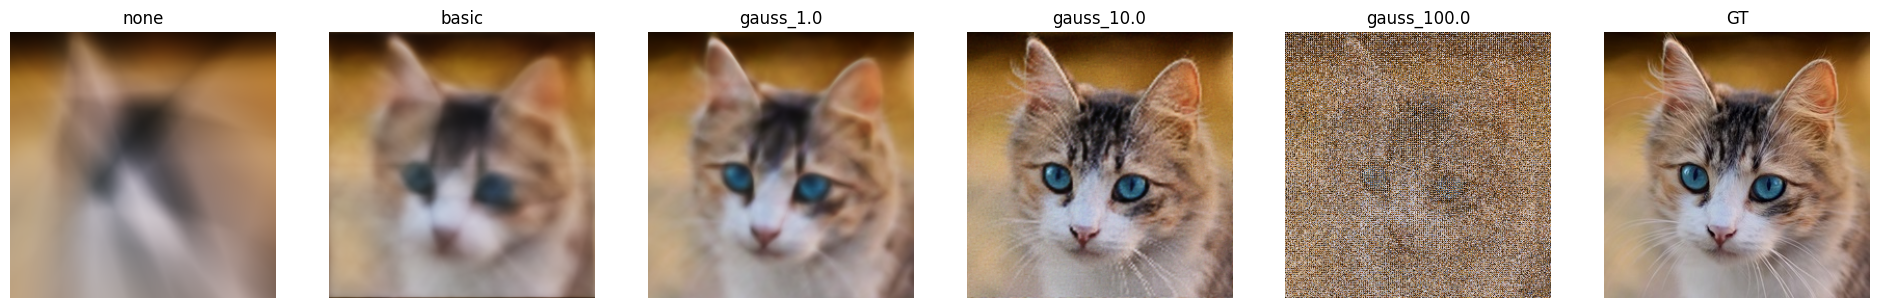

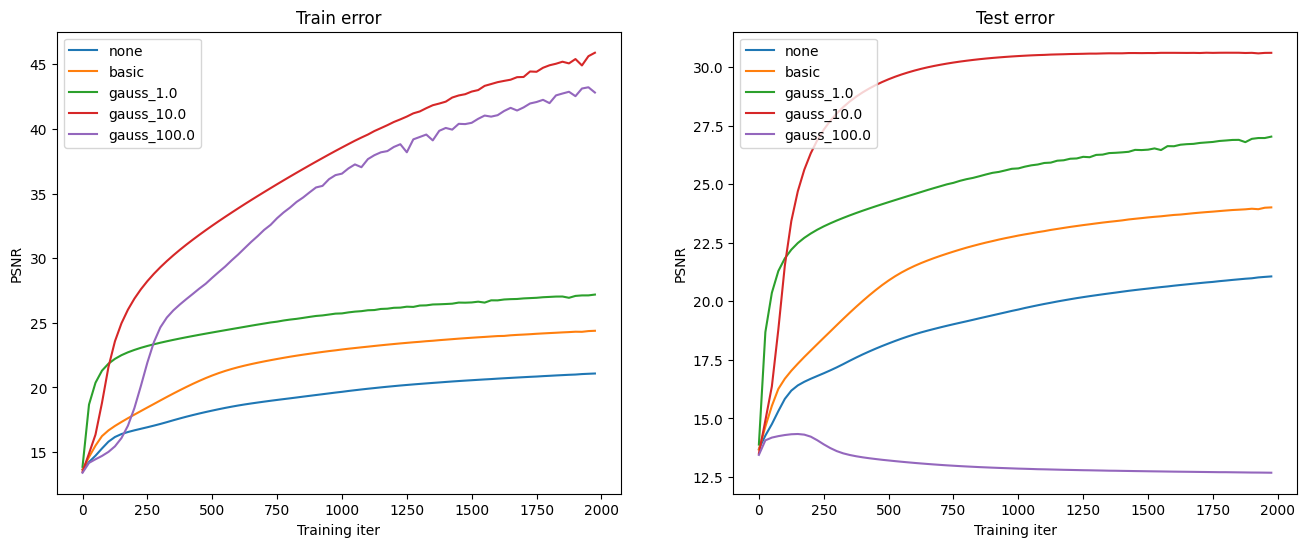

In [ ]:
plot_output(outputs)

## Questions

### Question 1

Implement the ideal, butterworth and gaussian bandpass filters as described in the next table:

![](images/bpfs.png)

### Question 2

**Laplacian Filter** in **frequency domain**: Implement the filter in the frequency domain, the frequency response is shown in the next table:

![](images/lap.png)

with the brick image you should obtain an output as shown in the next figure.

![](images/lap_freq.png)

### Question 3

**Homomorphic filter**: Implement the filter in the frequency domain. The frequency response may be described as:          
                              
![](images/homo.png)

where $\gamma_H  > 1$ and $\gamma_L  <1$, the constant $c$ controls smoothness. You need to apply the filter in log domain, since it aims at separating multiplicative components, low-frequency incidence from high- frequency reflectance (for details refer to this lecture: http://engr.case.edu/merat_francis/eecs490f07/Lectures/Lecture11.pdf). 

Given an image with non-uniform illumination as input, you should obtain an image with uniform illumination, as output of the homomorphic filter, as shown in next figure.

![](images/homo_out.png)